### My explanation is going inline with the module

## [Problem 1]

In [1]:
#importing the necessary liberies
import numpy as np
import pandas as pd
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [2]:
class FC:
    
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.W = initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = initializer.B(self.n_nodes2)
        self.optimizer = optimizer
        self.HW = 0
        self.HB = 0
        #for the forward propergation we store records that are train on the loss
    def forward(self, X):
        self.Z = X
        self.A = X @ self.W + self.B
        return self.A
   #for the backword propergation we do some calculations for the evaluation
    def backward(self, dA):
        self.dB = np.sum(dA, axis=0)
        self.dW = self.Z.T @ dA
        self.dZ = dA @ self.W.T
        self = self.optimizer.update(self)
        return self.dZ

## [Problem 2]

In [3]:
class SimpleInitializer:

    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

## [Problem 3]

In [4]:
class SGD:
    
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        layer.W -= self.lr * layer.dW / len(layer.Z)
        layer.B -= self.lr * layer.dB / len(layer.Z)
        return layer

## [Problem 4]

In [5]:
class Sigmoid:

    def forward(self, A):
        self.A = A
        Z = 1 / (1 + np.exp(-self.A))
        return Z
    
    def backward(self, dZ):
        dA = dZ * ((1 / (1 + np.exp(-self.A))) - (1 / (1 + np.exp(-self.A)))**2)
        return dA

In [6]:
class Tanh:

    def forward(self, A):
        self.A = A
        Z = np.tanh(self.A)
        return Z
    
    def backward(self, dZ):
        dA = dZ * (1 - np.tanh(self.A)**2)
        return dA

In [7]:
class softmax:

    def forward(self, A): 
        Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        return Z
        
    def backward(self, Z, y):
        dA = Z - y
        loss = - np.sum(y * np.log(Z)) / len(y)
        return dA, loss

## [Problem 5]

In [1]:
class ReLU:

    def forward(self, A):
        self.A = A
        Z = np.maximum(0, A)
        return Z
    
    def backward(self, dZ):
        dA = dZ * np.where(self.A > 0, 1, 0)
        return dA

## [Problem 6]

In [9]:
class XavierInitializer:
    
    def __init__(self, sigma):
        _ = sigma
        
    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1 / np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
        
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [10]:
class HeInitializer:

    def __init__(self, sigma):
        _ = sigma
        
    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

## [Problem 7]

In [11]:
class AdaGrad:

    def __init__(self, lr):
        self.lr = lr 
    
    def update(self, layer):
        layer.HW += layer.dW * layer.dW
        layer.HB += layer.dB * layer.dB
        delta = 1e-7 
        layer.W -= self.lr * layer.dW / (np.sqrt(layer.HW) + delta) / len(layer.Z)
        layer.B -= self.lr * layer.dB / (np.sqrt(layer.HB) + delta) / len(layer.Z)
        return layer

## [Problem 8]

In [12]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1] 
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [13]:
class ScratchDeepNeuralNetrowkClassifier():
#the values below are for the initialization
    def __init__(self, verbose=False, epoch=1, optimizer=SGD, initializer=HeInitializer, activater=ReLU):
        self.verbose = verbose
        self.batch_size = 20 
        self.n_features = 784 
        self.n_nodes1 = 400 
        self.n_nodes2 = 200     
        self.n_output = 10   #you can also make a change of the values to make a change in the network
        self.sigma = 0.02 
        self.lr = 0.5 
        self.epoch = epoch 
        self.optimizer = optimizer 
        self.initializer = initializer 
        self.activater = activater 
    
    def fit(self, X, y, X_val=None, y_val=None):
        self.loss_train = [] 
        self.loss_val = [] 
        optimizer = self.optimizer(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, self.initializer(self.sigma), optimizer)
        self.activation1 = self.activater()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.initializer(self.sigma), optimizer)
        self.activation2 = self.activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.initializer(self.sigma), optimizer)
        self.activation3 = softmax()
        
        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            for mini_X, mini_y in get_mini_batch:
                A1 = self.FC1.forward(mini_X)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                #print(Z2.shape)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                dA3, loss = self.activation3.backward(Z3, mini_y) 
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) 

            if self.verbose:
                A1 = self.FC1.forward(X)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)            
                self.loss_train.append(self.activation3.backward(Z3, y)[1])
                
                if X_val is not None:
                    A1 = self.FC1.forward(X_val)
                    Z1 = self.activation1.forward(A1)
                    A2 = self.FC2.forward(Z1)
                    Z2 = self.activation2.forward(A2)
                    A3 = self.FC3.forward(Z2)
                    Z3 = self.activation3.forward(A3)            
                    self.loss_val.append(self.activation3.backward(Z3, y_val)[1])
    
    def predict(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return np.argmax(Z3, axis=1)

## [Problem 9]

In [14]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [16]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_val[:, np.newaxis])

In [17]:
SDNN = ScratchDeepNeuralNetrowkClassifier(verbose=True, epoch=10, optimizer=AdaGrad, initializer=HeInitializer, activater=ReLU) 

SDNN.fit(X_train, y_train_one_hot, X_val, y_test_one_hot)

In [18]:
pred = SDNN.predict(X_val)
accuracy_score(y_val, pred)

0.979

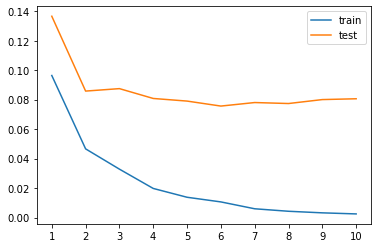

In [19]:
#in ploting we use the name of our object SDNN and the loss_train to visualize our result
import matplotlib.pyplot as plt
plt.plot(list(range(1, SDNN.epoch+1)), SDNN.loss_train, label='train')
plt.plot(list(range(1, SDNN.epoch+1)), SDNN.loss_val, label='test')
plt.legend()
plt.xticks(list(range(1, SDNN.epoch+1))); 

In [20]:
class ScratchDeepNeuralNetrowkClassifier_4():

    def __init__(self, verbose=False, epoch=1, optimizer=SGD, initializer=HeInitializer, activater=ReLU):
        self.verbose = verbose
        self.batch_size = 20 
        self.n_features = 784 
        self.n_nodes1 = 400 
        self.n_nodes2 = 200 
        self.n_nodes3 = 150 
        self.n_output = 10 
        self.sigma = 0.02 
        self.lr = 0.5 
        self.epoch = epoch 
        self.optimizer = optimizer 
        self.initializer = initializer 
        self.activater = activater 
    
    def fit(self, X, y, X_val=None, y_val=None):
        self.loss_train = [] 
        self.loss_val = []
        optimizer = self.optimizer(self.lr)

        self.FC1 = FC(self.n_features, self.n_nodes1, self.initializer(self.sigma), optimizer)
        self.activation1 = self.activater()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.initializer(self.sigma), optimizer)
        self.activation2 = self.activater()
        self.FC3 = FC(self.n_nodes2, self.n_nodes3, self.initializer(self.sigma), optimizer)
        self.activation3 = self.activater()
        self.FC4 = FC(self.n_nodes3, self.n_output, self.initializer(self.sigma), optimizer)
        self.activation4 = softmax()
        
        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            for mini_X, mini_y in get_mini_batch:
                self.forward(mini_X)
                self.backward(mini_y)
            
            if self.verbose:
                self.forward(X)
                self.loss_train.append(self.activation4.backward(self.Z4, y)[1])
                
                if X_val is not None:
                    self.forward(X_val)
                    self.loss_val.append(self.activation4.backward(self.Z4, y_val)[1])
    
    def forward(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        A4 = self.FC4.forward(Z3)
        self.Z4 = self.activation4.forward(A4)
        
    def backward(self, y):
        dA4, self.loss = self.activation4.backward(self.Z4, y) 
        dZ3 = self.FC4.backward(dA4)
        dA3 = self.activation3.backward(dZ3)
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dZ0 = self.FC1.backward(dA1) 
        
    def predict(self, X):
        self.forward(X)
        return np.argmax(self.Z4, axis=1) 

In [21]:
SDNN4 = ScratchDeepNeuralNetrowkClassifier_4(verbose=True, epoch=10, optimizer=AdaGrad, initializer=HeInitializer, activater=ReLU)
SDNN4.fit(X_train, y_train_one_hot, X_val, y_test_one_hot)

pred = SDNN4.predict(X_val)
accuracy_score(y_val, pred)

0.979

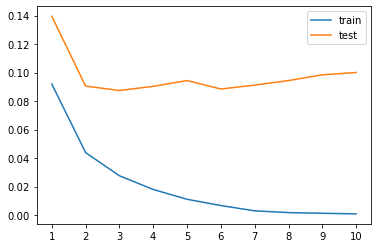

In [22]:
#in ploting we use the name of our object SDNN4 to visualize our result

plt.plot(list(range(1, SDNN4.epoch+1)), SDNN4.loss_train, label='train')
plt.plot(list(range(1, SDNN4.epoch+1)), SDNN4.loss_val, label='test')
plt.legend()
plt.xticks(list(range(1, SDNN4.epoch+1)));

In [23]:
class ScratchDeepNeuralNetrowkClassifier_6():

    def __init__(self, verbose=False, epoch=1, optimizer=SGD, initializer=HeInitializer, activater=ReLU):
        self.verbose = verbose
        self.batch_size = 20 
        self.n_features = 784 
        self.n_nodes1 = 400 
        self.n_nodes2 = 200 
        self.n_nodes3 = 150 
        self.n_nodes4 = 100 
        self.n_nodes5 = 50 
        self.n_output = 10 
        self.sigma = 0.02 
        self.lr = 0.5 
        self.epoch = epoch 
        self.optimizer = optimizer 
        self.initializer = initializer 
        self.activater = activater 
    
    def fit(self, X, y, X_val=None, y_val=None):
        self.loss_train = []     # a list to the train on the validation set
        self.loss_val = []
        optimizer = self.optimizer(self.lr)

        self.FC1 = FC(self.n_features, self.n_nodes1, self.initializer(self.sigma), optimizer)
        self.activation1 = self.activater()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.initializer(self.sigma), optimizer)
        self.activation2 = self.activater()
        self.FC3 = FC(self.n_nodes2, self.n_nodes3, self.initializer(self.sigma), optimizer)
        self.activation3 = self.activater()
        self.FC4 = FC(self.n_nodes3, self.n_nodes4, self.initializer(self.sigma), optimizer)
        self.activation4 = self.activater()
        self.FC5 = FC(self.n_nodes4, self.n_nodes5, self.initializer(self.sigma), optimizer)
        self.activation5 = self.activater()
        self.FC6 = FC(self.n_nodes5, self.n_output, self.initializer(self.sigma), optimizer)
        self.activation6 = softmax()
        
        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            for mini_X, mini_y in get_mini_batch:
                self.forward(mini_X)  #the forward propergation
                self.backward(mini_y)  #the backword propergation
            
            if self.verbose:
                self.forward(X)  #for the forward propergation we store records that are train on the loss
                self.loss_train.append(self.activation6.backward(self.Z6, y)[1])
                
                if X_val is not None: #if the validation set is included we are going to store the loss on the tess in the list
                    self.forward(X_val)
                    self.loss_val.append(self.activation6.backward(self.Z6, y_val)[1])
    
    def forward(self, X):   #for the forward propergation we are going to multiply x*w+b
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)  #we use an activation function
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        A4 = self.FC4.forward(Z3)
        Z4 = self.activation4.forward(A4)
        A5 = self.FC5.forward(Z4)
        Z5 = self.activation5.forward(A5)
        A6 = self.FC6.forward(Z5)
        self.Z6 = self.activation6.forward(A6)
        
    def backward(self, y):      #for the backword propergation we do some calculations for the evaluation
        dA6, self.loss = self.activation6.backward(self.Z6, y) 
        dZ5 = self.FC6.backward(dA6)
        dA5 = self.activation5.backward(dZ5)
        dZ4 = self.FC5.backward(dA5)
        dA4 = self.activation4.backward(dZ4)
        dZ3 = self.FC4.backward(dA4)
        dA3 = self.activation3.backward(dZ3)
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dZ0 = self.FC1.backward(dA1) 
        
    def predict(self, X):
        self.forward(X)
        return np.argmax(self.Z6, axis=1)  

In [24]:
SDNN6 = ScratchDeepNeuralNetrowkClassifier_6(verbose=True, epoch=10, optimizer=AdaGrad, initializer=HeInitializer, activater=ReLU)
SDNN6.fit(X_train, y_train_one_hot, X_val, y_test_one_hot)

pred = SDNN6.predict(X_val)
accuracy_score(y_val, pred)

0.97825

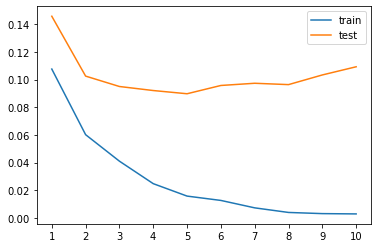

In [25]:
#in ploting we use the name of our object SDNN6 to visualize our result

plt.plot(list(range(1, SDNN6.epoch+1)), SDNN6.loss_train, label='train')
plt.plot(list(range(1, SDNN6.epoch+1)), SDNN6.loss_val, label='test')
plt.legend()
plt.xticks(list(range(1, SDNN6.epoch+1)));

In [26]:
class General_ScratchDeepNeuralNetrowkClassifier():

    def __init__(self, verbose=False, epoch=1, optimizer=SGD, initializer=HeInitializer, activater=ReLU, n_nodes=None):
        self.verbose = verbose
        self.batch_size = 20 
        self.sigma = 0.02
        self.lr = 0.5 
        self.epoch = epoch 
        self.optimizer = optimizer 
        self.initializer = initializer 
        self.activater = activater 
        self.n_nodes = n_nodes 
    
    def fit(self, X, y, X_val=None, y_val=None):
        self.loss_train = [] 
        self.loss_val = [] 
        optimizer = self.optimizer(self.lr)
        self.fcs = [] 
        self.act = [] 
        
        for i in range(len(self.n_nodes)-2):
            self.fcs.append(FC(self.n_nodes[i], self.n_nodes[i+1], self.initializer(self.sigma), optimizer))
            self.act.append(self.activater())
        self.fcs.append(FC(self.n_nodes[i+1], self.n_nodes[-1], self.initializer(self.sigma), optimizer))
        self.act.append(softmax())

        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            for mini_X, mini_y in get_mini_batch:
                A = []
                Z = []
                for i, (f, a) in enumerate(zip(self.fcs, self.act)):
                    if i == 0:
                        A.append(f.forward(mini_X))
                        Z.append(a.forward(A[i]))
                    else:
                        A.append(f.forward(Z[i-1]))
                        Z.append(a.forward(A[i]))     
                dA = []
                dZ = []
                for i, (f, a) in enumerate(zip(self.fcs[::-1], self.act[::-1])):
                    if i == 0:
                        dA.append(a.backward(Z[-(i+1)], mini_y)[0])
                        dZ.append(f.backward(dA[i]))
                    else:
                        dA.append(a.backward(dZ[i-1]))
                        dZ.append(f.backward(dA[i]))

            if self.verbose:
                A = []
                Z = []
                for i, (f, a) in enumerate(zip(self.fcs, self.act)):
                    if i == 0:
                        A.append(f.forward(X))
                        Z.append(a.forward(A[i]))
                    else:
                        A.append(f.forward(Z[i-1]))
                        Z.append(a.forward(A[i]))           
                self.loss_train.append(self.act[-1].backward(Z[-1], y)[1])
                
                if X_val is not None:
                    A = []
                    Z = []
                    for i, (f, a) in enumerate(zip(self.fcs, self.act)):
                        if i == 0:
                            A.append(f.forward(X_val))
                            Z.append(a.forward(A[i]))
                        else:
                            A.append(f.forward(Z[i-1]))
                            Z.append(a.forward(A[i]))           
                    self.loss_val.append(self.act[-1].backward(Z[-1], y_val)[1])
    
    def predict(self, X):
        A = []
        Z = []
        for i, (f, a) in enumerate(zip(self.fcs, self.act)):
            if i == 0:
                A.append(f.forward(X))
                Z.append(a.forward(A[i]))
            else:
                A.append(f.forward(Z[i-1]))
                Z.append(a.forward(A[i]))
        return np.argmax(Z[-1], axis=1)

In [27]:
node_list = [784, 400, 200, 150, 100, 10]
SDNN5 = General_ScratchDeepNeuralNetrowkClassifier(verbose=True, epoch=10, optimizer=AdaGrad, initializer=HeInitializer, activater=ReLU, n_nodes=node_list)
SDNN5.fit(X_train, y_train_one_hot, X_val, y_test_one_hot)
pred = SDNN5.predict(X_val)
accuracy_score(y_val, pred)

0.97875

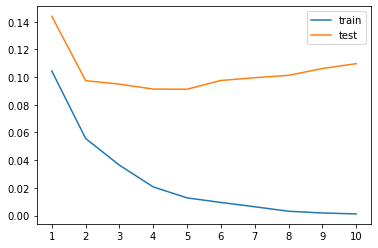

In [28]:
#in ploting we use the name of our object SDNN5 to visualize our result
plt.plot(list(range(1, SDNN5.epoch+1)), SDNN5.loss_train, label='train')
plt.plot(list(range(1, SDNN5.epoch+1)), SDNN5.loss_val, label='test')
plt.legend()
plt.xticks(list(range(1, SDNN5.epoch+1)));